## Spooky Author Identification

The competition dataset contains text from works of fiction written by spooky authors of the public domain: Edgar Allan Poe, HP Lovecraft and Mary Shelley. The data was prepared by chunking larger texts into sentences using CoreNLP's MaxEnt sentence tokenizer, so you may notice the odd non-sentence here and there. Your objective is to accurately identify the author of the sentences in the test set.

#### Data fields
* id - a unique identifier for each sentence
* text - some text written by one of the authors
* author - the author of the sentence (EAP: Edgar Allan Poe, HPL: HP Lovecraft; MWS: Mary Wollstonecraft Shelley)

You can also find the dataset <a href = "https://www.kaggle.com/competitions/spooky-author-identification/overview"> here</a>

***

### Import necessary libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras import Sequential , layers
from sklearn.metrics import confusion_matrix , classification_report ,accuracy_score

### Read 'spooky.csv' dataset

In [3]:
df=pd.read_csv('spooky.csv')

In [4]:
df.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


### Drop 'id' column

In [6]:
df.drop(columns='id',inplace=True)

In [8]:
df.head()

,text,author
0,"This process, however, afforded me no means of...",EAP
1,It never once occurred to me that the fumbling...,HPL
2,"In his left hand was a gold snuff box, from wh...",EAP
3,How lovely is spring As we looked from Windsor...,MWS
4,"Finding nothing else, not even gold, the Super...",HPL


### Check for missing values

In [9]:
df.isna().sum()

text      0
author    0
dtype: int64

### Check for duplicates

In [13]:
df.duplicated().sum()

0

### Print some of the text along with its author

In [16]:
for i in range(5):
    print(df['text'][i])
    print()

This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wall.

It never once occurred to me that the fumbling might be a mere mistake.

In his left hand was a gold snuff box, from which, as he capered down the hill, cutting all manner of fantastic steps, he took snuff incessantly with an air of the greatest possible self satisfaction.

How lovely is spring As we looked from Windsor Terrace on the sixteen fertile counties spread beneath, speckled by happy cottages and wealthier towns, all looked as in former years, heart cheering and fair.

Finding nothing else, not even gold, the Superintendent abandoned his attempts; but a perplexed look occasionally steals over his countenance as he sits thinking at his desk.



### Create a function to preproces the text

In [19]:
def preprocess(text):
    text=re.sub(r'[^a-zA-Z0-9]',' ',text).split()
    words=[i.lower() for i in text]
    lemma=WordNetLemmatizer()
    word=[lemma.lemmatize(i,'v') for i in words]
    return ' '.join(word)

In [20]:
df['text']=df['text'].apply(preprocess)

### Print some of the text after preprocess

In [21]:
for i in range(5):
    print(df['text'][i])
    print()

this process however afford me no mean of ascertain the dimension of my dungeon as i might make its circuit and return to the point whence i set out without be aware of the fact so perfectly uniform seem the wall

it never once occur to me that the fumble might be a mere mistake

in his leave hand be a gold snuff box from which as he caper down the hill cut all manner of fantastic step he take snuff incessantly with an air of the greatest possible self satisfaction

how lovely be spring as we look from windsor terrace on the sixteen fertile counties spread beneath speckle by happy cottages and wealthier towns all look as in former years heart cheer and fair

find nothing else not even gold the superintendent abandon his attempt but a perplex look occasionally steal over his countenance as he sit think at his desk



### Check for imbalance in the dataset

<Axes: xlabel='count', ylabel='author'>

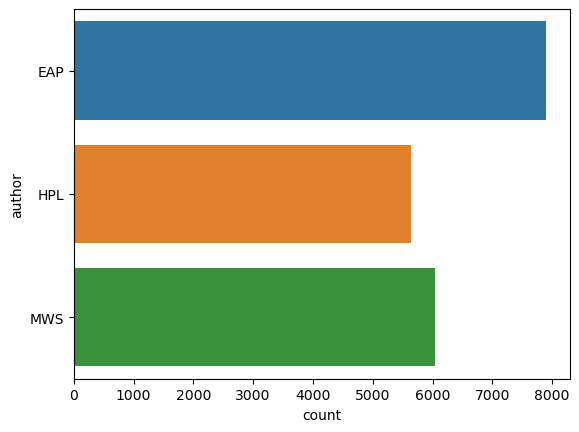

In [22]:
sns.countplot(y=df['author'])

In [25]:
count=df['author'].value_counts()

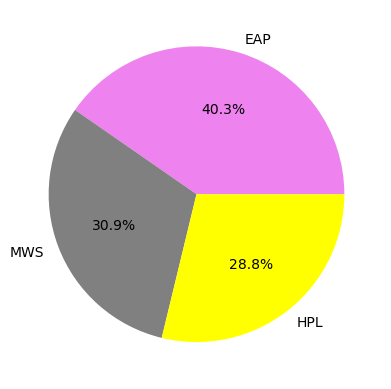

In [34]:
plt.pie(count,labels=count.index ,autopct='%1.1f%%' , colors=['violet','gray','yellow'])
plt.show()

### Split the dataset into Input & Target Variables

In [69]:
x=df['text']
y=df['author']

### Label Encode our target variables

In [70]:
encoder=LabelBinarizer()

In [71]:
y=encoder.fit_transform(y)

### Split the dataset into Training & Testing set

In [72]:
X_train,X_test,y_train,y_test=train_test_split(x,y,train_size=.25,random_state=100)

### Create Keras tokenizer object with 5000 max words
* Convert text to sequence
* Add padding

In [73]:
tokenizer=Tokenizer(num_words=5000)

In [74]:
tokenizer.fit_on_texts(x)

In [75]:
vocab=len(tokenzier.word_index)+1

In [76]:
def padding(txt):
    tokenize=tokenizer.texts_to_sequences(txt)
    padding=pad_sequences(tokenize,maxlen=128)
    return padding

In [77]:
X_train=padding(X_train)
X_test=padding(X_test)

### Create keras Sequential model with GRU layers

In [78]:
import keras

In [81]:
model=Sequential([
    keras.layers.Embedding(vocab, 128),
    keras.layers.GRU(128,return_sequences=True),
    keras.layers.Dropout(0.2),
    keras.layers.GRU(128),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(3,activation='sigmoid')
])

In [82]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         2509056   
                                                                 
 gru (GRU)                   (None, None, 128)         99072     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 gru_1 (GRU)                 (None, 128)               99072     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 3)                 387       
                                                                 
Total params: 2707587 (10.33 MB)
Trainable params: 27075

### Compile the model

In [ ]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [83]:
model.compile(loss= 'categorical_crossentropy', optimizer='adam' , metrics=['accuracy'])

### Train the model

In [84]:
model.fit(X_train,y_train ,epochs=10 ,validation_split=0.2)

Epoch 1/10
123/123 [==============================] - 53s 360ms/step - loss: 0.9337 - accuracy: 0.5430 - val_loss: 0.7016 - val_accuracy: 0.6997
Epoch 2/10
123/123 [==============================] - 32s 258ms/step - loss: 0.4630 - accuracy: 0.8204 - val_loss: 0.6202 - val_accuracy: 0.7273
Epoch 3/10
123/123 [==============================] - 33s 268ms/step - loss: 0.2275 - accuracy: 0.9134 - val_loss: 0.8181 - val_accuracy: 0.6905
Epoch 4/10
123/123 [==============================] - 34s 273ms/step - loss: 0.1437 - accuracy: 0.9517 - val_loss: 1.0370 - val_accuracy: 0.7058
Epoch 5/10
123/123 [==============================] - 33s 272ms/step - loss: 0.0745 - accuracy: 0.9724 - val_loss: 1.2168 - val_accuracy: 0.6864
Epoch 6/10
123/123 [==============================] - 33s 269ms/step - loss: 0.0615 - accuracy: 0.9788 - val_loss: 1.2667 - val_accuracy: 0.7252
Epoch 7/10
123/123 [==============================] - 33s 270ms/step - loss: 0.0433 - accuracy: 0.9867 - val_loss: 1.4108 - val_ac

### Make predictions with X_test

In [85]:
prediction=model.predict(X_test)

459/459 [==============================] - 22s 46ms/step


### Fetch the index of the higher probable prediction

In [87]:
y_pred=[np.argmax(i) for i in prediction]

In [ ]:
y_test=[np.argmax(i) for i in y_test]

### Evaluate the model

In [89]:
model.evaluate(X_train,y_train)

153/153 [==============================] - 8s 49ms/step - loss: 0.3739 - accuracy: 0.9367


[0.37391215562820435, 0.9366571307182312]

#### Accuracy score

In [98]:
accuracy_score(y_test,y_pred)

0.7072522982635342

#### Confusion matrix

<Axes: >

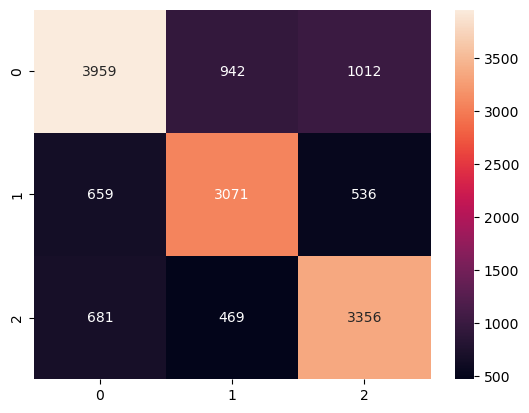

In [99]:
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True ,fmt='d')

#### Classification Report

In [100]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.67      0.71      5913
           1       0.69      0.72      0.70      4266
           2       0.68      0.74      0.71      4506

    accuracy                           0.71     14685
   macro avg       0.71      0.71      0.71     14685
weighted avg       0.71      0.71      0.71     14685



### Email:shamilmskeeri@gmail.com

***